In [15]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import random_split , DataLoader
import copy
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
#Load Dataset: CIFAR-10

transform = transforms.Compose([   # used in torchvision.datasets.CIFAR10()
    transforms.Resize(224),   # ResNet50 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

final_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

In [17]:
from collections import Counter
targets = [target for _, target in final_dataset]

# Count the occurrences of each class
class_counts = Counter(targets)

print("Class Distribution:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count}")

Class Distribution:
Class 6: 6000
Class 9: 6000
Class 4: 6000
Class 1: 6000
Class 2: 6000
Class 7: 6000
Class 8: 6000
Class 3: 6000
Class 5: 6000
Class 0: 6000


In [18]:
total_size = len(final_dataset)
train_size = int(0.7*total_size) #70%
val_size = int(0.15*total_size) #15%
test_size = int(0.15*total_size) #15%

train_dataset, val_dataset, test_dataset = random_split(final_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [19]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer initially
# for param in model.parameters():
#     param.requires_grad = False

# Add Dropout layers to specific layers
# We'll add dropout after some of the bottleneck blocks in layer3 and layer4
class ResNet50WithMoreDropout(nn.Module):
    def __init__(self, original_resnet, dropout_prob=0.5):
        super(ResNet50WithMoreDropout, self).__init__()
        self.conv1 = original_resnet.conv1
        self.bn1 = original_resnet.bn1
        self.relu = original_resnet.relu
        self.maxpool = original_resnet.maxpool
        self.layer1 = original_resnet.layer1


        self.layer2 = nn.Sequential()
        for i, block in enumerate(original_resnet.layer2):
            self.layer2.add_module(f"block{i}", block)
            if i % 2 == 1: # Add dropout after every other block in layer3
                self.layer2.add_module(f"dropout{i}", nn.Dropout(dropout_prob))

        # Add dropout within layer3
        self.layer3 = nn.Sequential()
        for i, block in enumerate(original_resnet.layer3):
            self.layer3.add_module(f"block{i}", block)
            if i % 2 == 1: # Add dropout after every other block in layer3
                self.layer3.add_module(f"dropout{i}", nn.Dropout(dropout_prob))

        # Add dropout within layer4
        self.layer4 = nn.Sequential()
        for i, block in enumerate(original_resnet.layer4):
            self.layer4.add_module(f"block{i}", block)
            if i % 1 == 0: # Add dropout after every block in layer4
                 self.layer4.add_module(f"dropout{i}", nn.Dropout(dropout_prob))

        self.avgpool = original_resnet.avgpool

        # Modify the final fully connected layer with dropout before it
        num_features = original_resnet.fc.in_features
        self.fc = nn.Sequential(
            nn.Dropout(dropout_prob),  # Add a dropout layer before the final classification layer
            nn.Linear(num_features, 10)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Create a new model with dropout in more layers
model = ResNet50WithMoreDropout(model)

# Unfreeze the parameters of the new final classification layer (which includes dropout)
# for param in model.fc.parameters():
#     param.requires_grad = True

model.to(device)

# You will need to re-initialize your optimizer to include the newly unfrozen parameters
# For example:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay =0.01)
# criterion = torch.nn.CrossEntropyLoss()
# ... training loop using model and your data loaders ...

ResNet50WithMoreDropout(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1


Epoch 1/20
--------------------
Train Loss: 2.4923 Acc: 0.1050
Val Loss: 2.3006 Acc: 0.1082
✔️ Saved best model

Epoch 2/20
--------------------
Train Loss: 2.3187 Acc: 0.1126
Val Loss: 2.2995 Acc: 0.1019
✔️ Saved best model

Epoch 3/20
--------------------
Train Loss: 2.2701 Acc: 0.1352
Val Loss: 2.2958 Acc: 0.1128
✔️ Saved best model

Epoch 4/20
--------------------
Train Loss: 2.1380 Acc: 0.1844
Val Loss: 2.2671 Acc: 0.1428
✔️ Saved best model

Epoch 5/20
--------------------
Train Loss: 1.8529 Acc: 0.2655
Val Loss: 2.0236 Acc: 0.2440
✔️ Saved best model

Epoch 6/20
--------------------
Train Loss: 1.5985 Acc: 0.3732
Val Loss: 1.6516 Acc: 0.3738
✔️ Saved best model

Epoch 7/20
--------------------
Train Loss: 1.3564 Acc: 0.4903
Val Loss: 1.4553 Acc: 0.4603
✔️ Saved best model

Epoch 8/20
--------------------
Train Loss: 1.1545 Acc: 0.5872
Val Loss: 1.1787 Acc: 0.5739
✔️ Saved best model

Epoch 9/20
--------------------
Train Loss: 0.9571 Acc: 0.6740
Val Loss: 0.9943 Acc: 0.6403
✔️ 

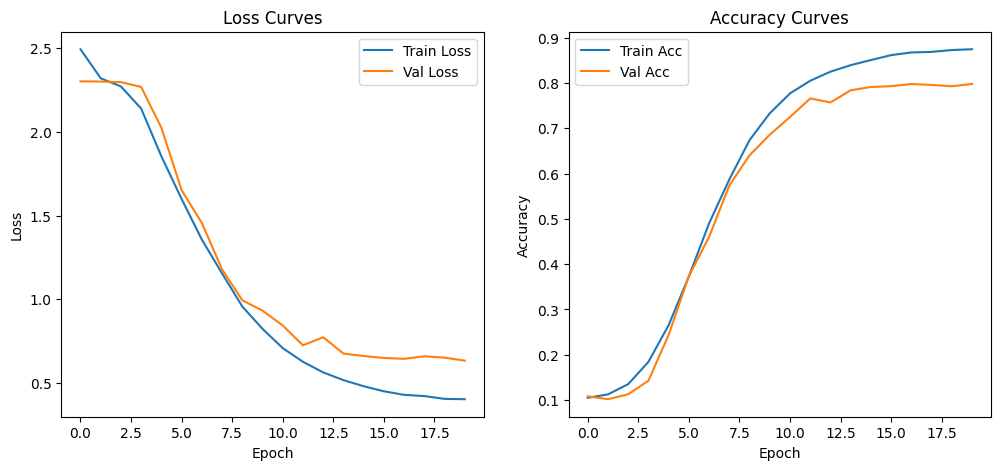

In [20]:
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 20

optimizer = torch.optim.Adamax(model.parameters(), lr=0.001, weight_decay =0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs) # Add scheduler

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')

# Early stopping parameters
early_stopping_patience = 5  # Number of epochs to wait for improvement
epochs_no_improve = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # Training phase
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc.item())

    print(f"Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Save best weights and check for early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_resnet50_cifar10.pth")
        print("✔️ Saved best model")
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print(f"Early stopping after {epoch+1} epochs due to no improvement in validation loss.")
        break  # Stop training loop

    scheduler.step() # Step the scheduler at the end of the epoch


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.show()

In [21]:
model.load_state_dict(best_model_wts)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

✅ Test Accuracy: 80.97%
